# **Pendeteksian APT menggunakan algoritma machine learning berbasis transformer**

# **Importing Modules and Libraries**

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# **Importing Datasets**

In [ ]:
# Load datasets
unsw_df = pd.read_csv('unswtrain.csv')

# Lihat kolom masing-masing dataset
print("Kolom UNSW:", unsw_df.columns)


Kolom UNSW: Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [ ]:
unsw_df.head(n=5)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
# Memeriksa nilai yang hilang
unsw_df.isnull().sum()


,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


In [ ]:
# Menggunakan LabelEncoder untuk kolom kategorikal
label_encoder = LabelEncoder()

# Encode beberapa kolom kategorikal
unsw_df['proto'] = label_encoder.fit_transform(unsw_df['proto'])
unsw_df['state'] = label_encoder.fit_transform(unsw_df['state'])
unsw_df['service'] = label_encoder.fit_transform(unsw_df['service'])
unsw_df['attack_cat'] = label_encoder.fit_transform(unsw_df['attack_cat'])

# Jika ada kolom yang tidak perlu di-encode, Anda bisa melewatkannya.


In [ ]:
# Menentukan fitur (X) dan target (y)
X = unsw_df.drop(['id', 'label', 'attack_cat'], axis=1)  # Fitur (tanpa id, label, attack_cat)
y = unsw_df['label']  # Target (label untuk klasifikasi APT dan Normal)


Ini adalah proses atau tahapan persiapan data yang baik sebelum dilanjutkan ke tahap analisis atau pemodelan.

# **Data Visualization**

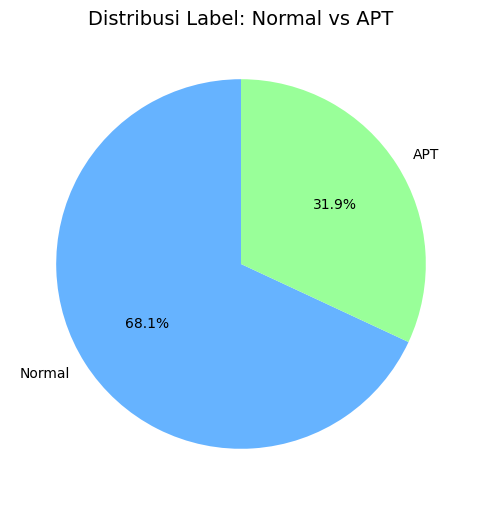

In [ ]:
# Menghitung jumlah masing-masing label
label_counts = unsw_df['label'].value_counts()

# Membuat Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['Normal', 'APT'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])

# Menambahkan judul
plt.title('Distribusi Label: Normal vs APT', fontsize=14)
plt.show()


# **Label Encoding**

In [ ]:
# changing attack labels into two categories 'normal' and 'abnormal'
bin_label = pd.DataFrame(unsw_df.label.map(lambda x:'normal' if x==0 else 'apt'))



In [ ]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = unsw_df.copy()
bin_data['label'] = bin_label


In [ ]:
# label encoding (0,1) binary labels
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['label'] = enc_label


In [ ]:
le1.classes_


array(['apt', 'normal'], dtype=object)

In [ ]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

# **DATA SPLITTING**

In [ ]:
# 1. Mengimpor Modul yang Diperlukan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from os import path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


In [ ]:

X_bin = bin_data.drop(columns=['label'],axis=1)
y_bin = bin_data['label']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.2, random_state=50)


In [ ]:
# Menampilkan jumlah data pada masing-masing subset
print("Jumlah data training (X_train_bin):", X_train_bin.shape[0])
print("Jumlah data testing (X_test_bin):", X_test_bin.shape[0])
print("Jumlah label training (y_train_bin):", y_train_bin.shape[0])
print("Jumlah label testing (y_test_bin):", y_test_bin.shape[0])


Jumlah data training (X_train_bin): 140272
Jumlah data testing (X_test_bin): 35069
Jumlah label training (y_train_bin): 140272
Jumlah label testing (y_test_bin): 35069


# **LIBRARY TRANSFORMER**

Instalasi Paket yang Diperlukan

Instalasi paket: Menginstal berbagai paket yang diperlukan untuk pembelajaran mesin dan pemrosesan data.

In [ ]:
!pip install transformers tensorflow scikit-learn matplotlib pandas


# **1. TRANSFORMER "ENCODER"**

# **CLASSIFICATION Non-Tuning**

In [ ]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

ini dirunning sendiri ya

Fold 1
Accuracy for fold 1: 100.00%
F1 Score for fold 1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5519
           1       1.00      1.00      1.00     12016

    accuracy                           1.00     17535
   macro avg       1.00      1.00      1.00     17535
weighted avg       1.00      1.00      1.00     17535



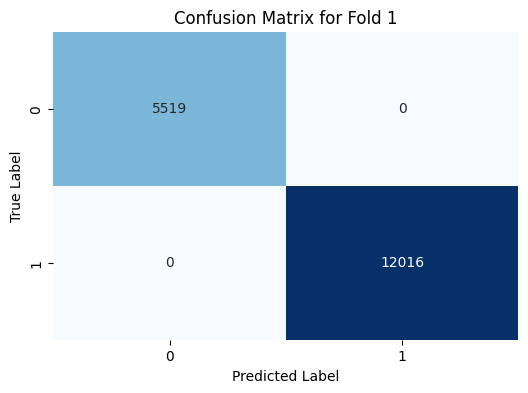

Fold 2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Label Encoding
# Label Encoding untuk kolom 'Label'
label_encoder = LabelEncoder()
unsw_df['Label_encoded'] = label_encoder.fit_transform(unsw_df['label'])
# Convert class_names to a list of strings
class_names = [str(name) for name in label_encoder.classes_]


# 2. Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)  # Output layer

    def forward(self, x):
        x = self.embedding(x)  # Embed the input features
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_length, feature_dim)
        x = self.transformer_encoder(x)  # Pass through the transformer encoder
        x = x.mean(dim=1)  # Average pooling
        return self.fc(x)  # Final output

# 3. KFold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=50)  # 10 untuk tubes
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []
average_val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(unsw_df)):
    print(f'Fold {fold + 1}')

    # Split data
    X_train, X_val = unsw_df.drop(columns=['label', 'Label_encoded']).iloc[train_index], \
                     unsw_df.drop(columns=['label', 'Label_encoded']).iloc[val_index]
    y_train, y_val = unsw_df['Label_encoded'].iloc[train_index], unsw_df['Label_encoded'].iloc[val_index]

    # Ensure numeric data and handle missing values
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val.values)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Initialize model, loss, and optimizer
    model = TransformerModel(input_dim=X_train_tensor.shape[1], num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping setup
    best_accuracy = 0
    best_loss = float('inf')  # Initialize best_loss for early stopping
    patience, trigger_times = 5, 0

    # Train the model
    num_epochs = 20  # Set to 20 for better training tubes
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val, y_pred.numpy())
        val_accuracies.append(accuracy)

        # Early stopping based on validation loss
        if avg_loss < best_loss:  # Monitor loss for early stopping
            best_loss = avg_loss
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break

    # Metrics calculation
    conf_matrix = confusion_matrix(y_val, y_pred.numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)
    f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
    all_f1_scores.append(f1)

    # Print results for the current fold
    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    print(classification_report(y_val, y_pred.numpy(), target_names=class_names))

    # Store for plotting
    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)

    # Plot confusion matrix for the current fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

# 4. Average Metrics Across All Folds
print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# 5. Plot the Average Confusion Matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# 6. Plot Loss and Accuracy for Each Fold
for fold in range(len(average_train_losses)):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
    plt.title(f'Training Loss for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
    plt.title(f'Validation Accuracy for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


# **Hyperparameter Tuning**

In [ ]:
from itertools import product
# Added the import for KFold
from sklearn.model_selection import KFold
from itertools import product
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# Define hyperparameter space
learning_rates = [0.001, 0.0005]
num_layers_list = [2, 3]
d_models = [64, 128]

# Store results for tracking the best hyperparameters
best_accuracy = 0
best_params = {}

# 1. Label Encoding
# Label Encoding untuk kolom 'Label'
label_encoder = LabelEncoder()
unsw_df['Label_encoded'] = label_encoder.fit_transform(unsw_df['label'])
# Convert class_names to a list of strings
class_names = [str(name) for name in label_encoder.classes_]


# 2. Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)  # Output layer

    def forward(self, x):
        x = self.embedding(x)  # Embed the input features
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_length, feature_dim)
        x = self.transformer_encoder(x)  # Pass through the transformer encoder
        x = x.mean(dim=1)  # Average pooling
        return self.fc(x)  # Final output

# Iterate over all combinations of hyperparameters
for lr, num_layers, d_model in product(learning_rates, num_layers_list, d_models):
    print(f'Tuning with lr={lr}, num_layers={num_layers}, d_model={d_model}')

    all_accuracy, all_f1_scores = [], []  # Reset for each run
    conf_matrix_list = []

    # 10-fold Cross-Validation (can adjust n_splits if needed)
    kf = KFold(n_splits=10, shuffle=True, random_state=50)

    for fold, (train_index, val_index) in enumerate(kf.split(data)):
        print(f'Fold {fold + 1}')

        # Split data
        X_train, X_val = combined_df.drop(columns=['Label', 'Label_encoded']).iloc[train_index], \
                         combined_df.drop(columns=['Label', 'Label_encoded']).iloc[val_index]
        y_train, y_val = combined_df['Label_encoded'].iloc[train_index], combined_df['Label_encoded'].iloc[val_index]

        # Ensure numeric data and handle missing values
        X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)

        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.LongTensor(y_train.values)
        X_val_tensor = torch.FloatTensor(X_val.values)
        y_val_tensor = torch.LongTensor(y_val.values)

        # Create DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

        # Initialize model with current hyperparameters
        model = TransformerModel(input_dim=X_train_tensor.shape[1],
                                 num_classes=len(class_names),
                                 d_model=d_model,
                                 num_layers=num_layers)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Train the model
        num_epochs = 20  # Use 20 epoch for tubes
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val, y_pred.numpy())
        f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
        all_accuracy.append(accuracy)
        all_f1_scores.append(f1)

        # Confusion matrix
        conf_matrix = confusion_matrix(y_val, y_pred.numpy())
        conf_matrix_list.append(conf_matrix)

    # Calculate average accuracy across all folds
    avg_accuracy = np.mean(all_accuracy)
    avg_f1_score = np.mean(all_f1_scores)

    print(f'Average Accuracy: {avg_accuracy * 100:.2f}%')
    print(f'Average F1 Score: {avg_f1_score:.4f}')

    # Track the best hyperparameters
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = {
            'learning_rate': lr,
            'num_layers': num_layers,
            'd_model': d_model
        }

print(f'Best Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_accuracy * 100:.2f}%')


# **CLASSIFICATION With Hyperparameter Tuning**
(ganti parameter sesuai yang terbaik hasil hyperparameter tuning ya)

Fold 1
Accuracy for fold 1: 100.00%
F1 Score for fold 1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11068
           1       1.00      1.00      1.00     24001

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



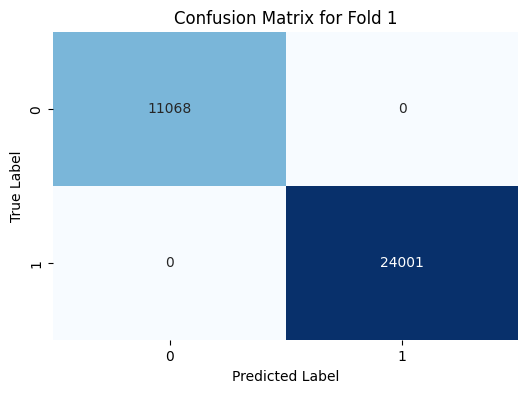

Fold 2
Accuracy for fold 2: 100.00%
F1 Score for fold 2: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11269
           1       1.00      1.00      1.00     23799

    accuracy                           1.00     35068
   macro avg       1.00      1.00      1.00     35068
weighted avg       1.00      1.00      1.00     35068



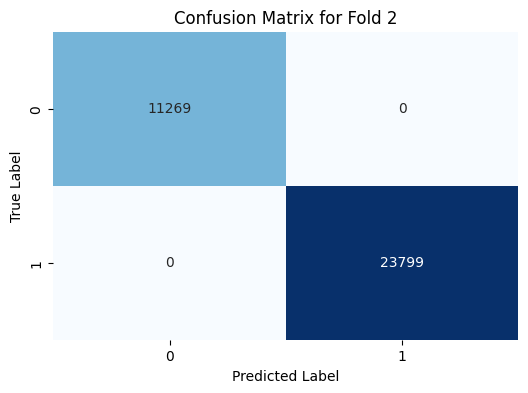

Fold 3
Early stopping triggered at epoch 20
Accuracy for fold 3: 99.99%
F1 Score for fold 3: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11293
           1       1.00      1.00      1.00     23775

    accuracy                           1.00     35068
   macro avg       1.00      1.00      1.00     35068
weighted avg       1.00      1.00      1.00     35068



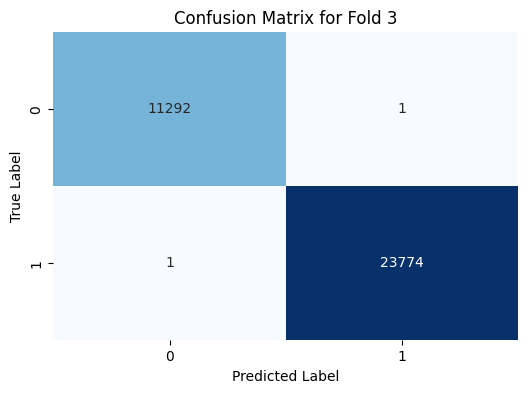

Fold 4
Accuracy for fold 4: 99.99%
F1 Score for fold 4: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11125
           1       1.00      1.00      1.00     23943

    accuracy                           1.00     35068
   macro avg       1.00      1.00      1.00     35068
weighted avg       1.00      1.00      1.00     35068



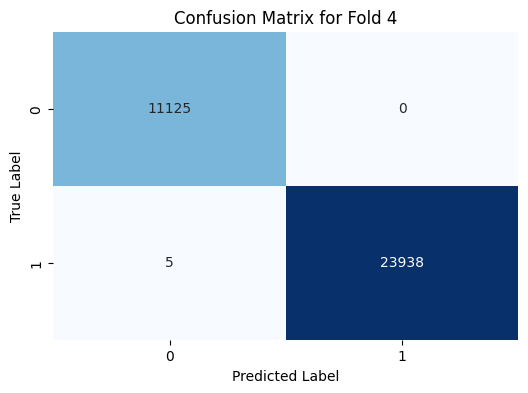

Fold 5
Early stopping triggered at epoch 18
Accuracy for fold 5: 99.90%
F1 Score for fold 5: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11245
           1       1.00      1.00      1.00     23823

    accuracy                           1.00     35068
   macro avg       1.00      1.00      1.00     35068
weighted avg       1.00      1.00      1.00     35068



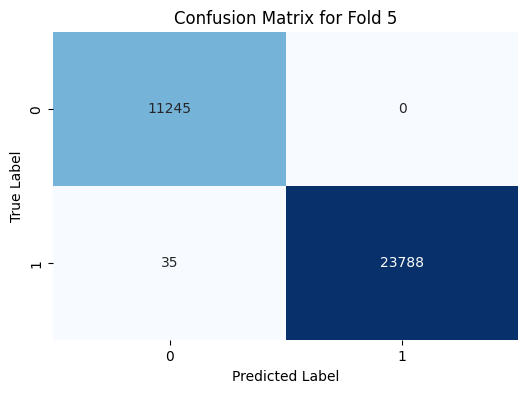

Average Accuracy: 99.98%
Average F1 Score: 0.9998


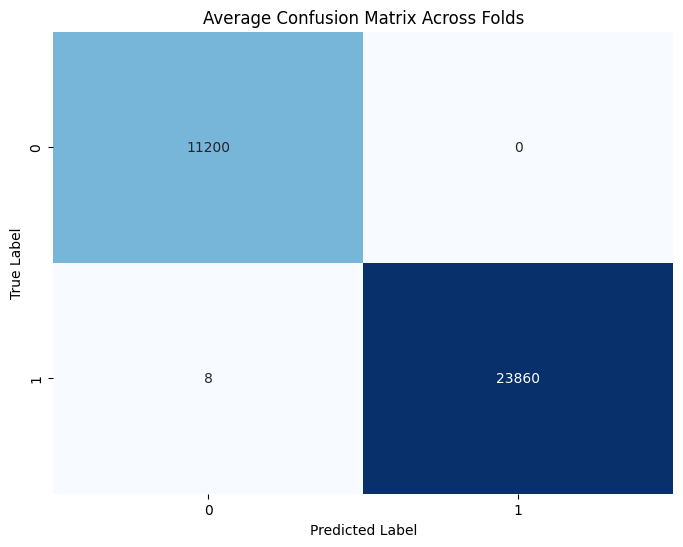

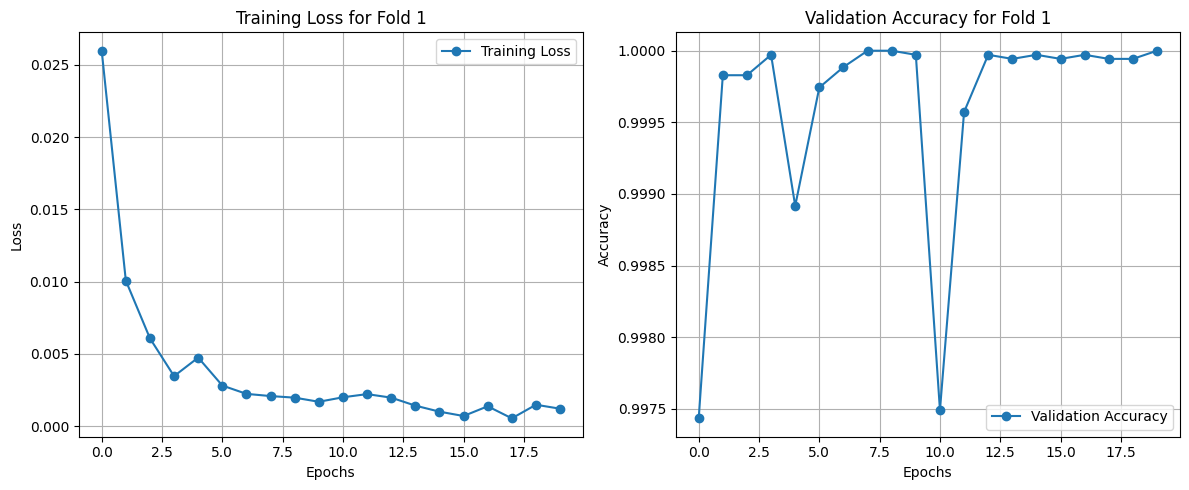

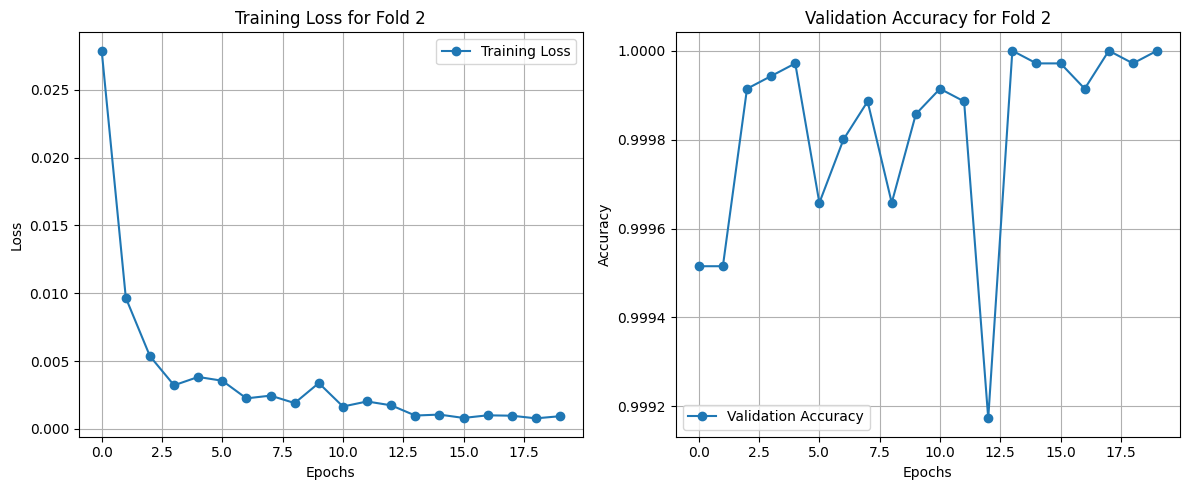

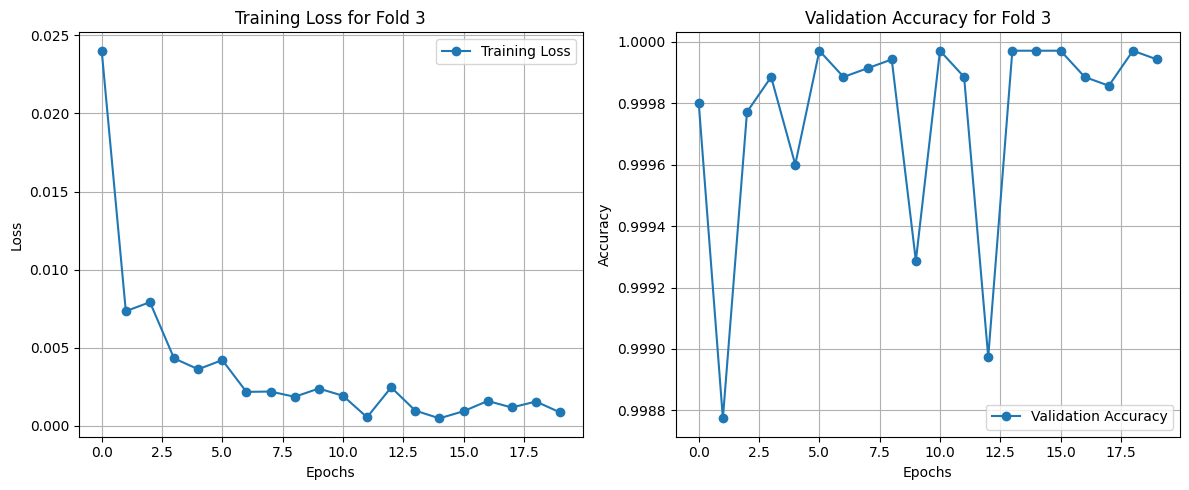

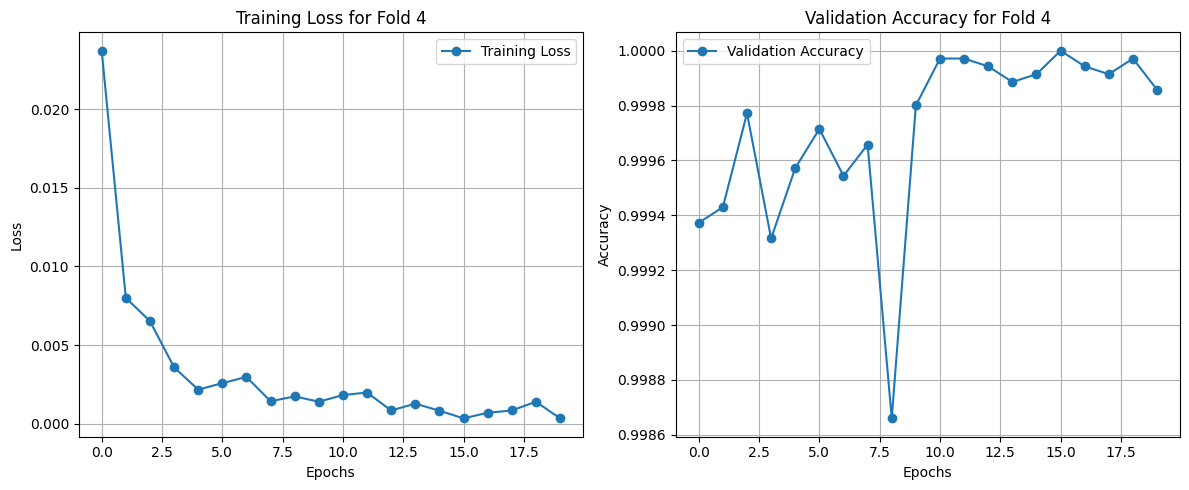

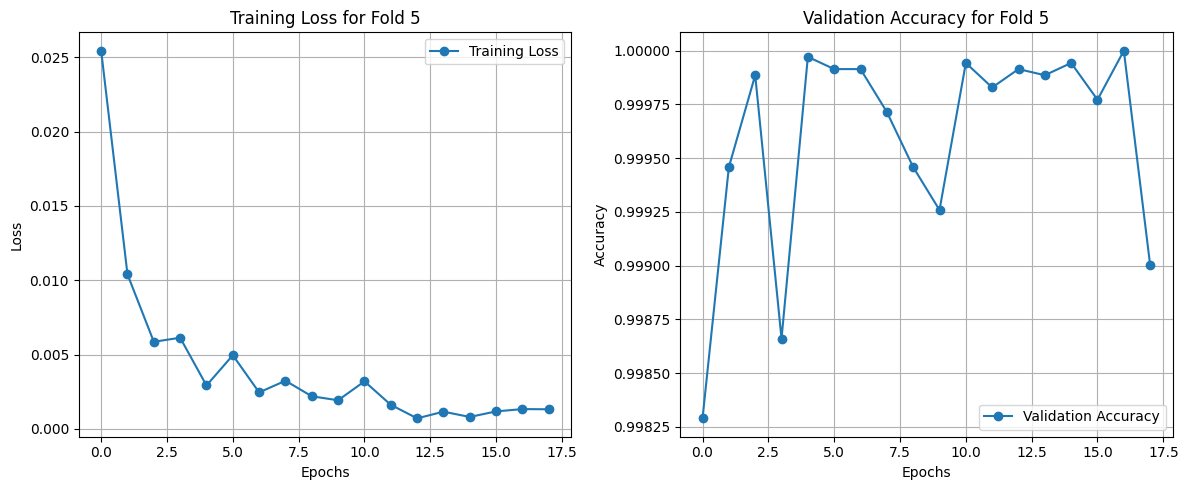

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Label Encoding
# Label Encoding untuk kolom 'Label'
label_encoder = LabelEncoder()
unsw_df['Label_encoded'] = label_encoder.fit_transform(unsw_df['label'])
# Convert class_names to a list of strings
class_names = [str(name) for name in label_encoder.classes_]


# 2. Define Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)  # Output layer

    def forward(self, x):
        x = self.embedding(x)  # Embed the input features
        x = x.unsqueeze(1)  # Add sequence dimension (batch_size, seq_length, feature_dim)
        x = self.transformer_encoder(x)  # Pass through the transformer encoder
        x = x.mean(dim=1)  # Average pooling
        return self.fc(x)  # Final output

# 3. KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=50)  # 10 untuk tubes
all_accuracy, all_f1_scores = [], []
conf_matrix_list = []
average_train_losses = []
average_val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(unsw_df)):
    print(f'Fold {fold + 1}')

    # Split data
    X_train, X_val = unsw_df.drop(columns=['label', 'Label_encoded']).iloc[train_index], \
                     unsw_df.drop(columns=['label', 'Label_encoded']).iloc[val_index]
    y_train, y_val = unsw_df['Label_encoded'].iloc[train_index], unsw_df['Label_encoded'].iloc[val_index]

    # Ensure numeric data and handle missing values
    X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.LongTensor(y_val.values)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.FloatTensor(class_weights)

    # Initialize model, loss, and optimizer
    model = TransformerModel(input_dim=X_train_tensor.shape[1], num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping setup
    best_accuracy = 0
    best_loss = float('inf')  # Initialize best_loss for early stopping
    patience, trigger_times = 5, 0

    # Train the model
    num_epochs = 20  # Set to 20 for better training tubes
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validate the model
        model.eval()
        with torch.no_grad():
            y_pred_probs = model(X_val_tensor)
            _, y_pred = torch.max(y_pred_probs, 1)

        accuracy = accuracy_score(y_val, y_pred.numpy())
        val_accuracies.append(accuracy)

        # Early stopping based on validation loss
        if avg_loss < best_loss:  # Monitor loss for early stopping
            best_loss = avg_loss
            torch.save(model.state_dict(), f'model_best_fold_{fold + 1}.pt')
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break

    # Metrics calculation
    conf_matrix = confusion_matrix(y_val, y_pred.numpy())
    conf_matrix_list.append(conf_matrix)
    all_accuracy.append(accuracy)
    f1 = f1_score(y_val, y_pred.numpy(), average='weighted')
    all_f1_scores.append(f1)

    # Print results for the current fold
    print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
    print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
    print(classification_report(y_val, y_pred.numpy(), target_names=class_names))

    # Store for plotting
    average_train_losses.append(train_losses)
    average_val_accuracies.append(val_accuracies)

    # Plot confusion matrix for the current fold
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Fold {fold + 1}')
    plt.show()

# 4. Average Metrics Across All Folds
print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# 5. Plot the Average Confusion Matrix
average_conf_matrix = np.mean(conf_matrix_list, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# 6. Plot Loss and Accuracy for Each Fold
for fold in range(len(average_train_losses)):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
    plt.title(f'Training Loss for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
    plt.title(f'Validation Accuracy for Fold {fold + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
